In [1]:
import json
import pandas as pd
import numpy as np

def uniform_sampling_from_dataset(csv_path: str, json_path: str, n_groups: int = 20):
    """
    """

    with open(json_path, 'r') as f:
        contour_data = json.load(f)
    df_json = pd.DataFrame.from_dict(contour_data, orient='index')
    df_json['image_name'] = df_json.index
    df_json = df_json.reset_index(drop=True)
    df_csv = pd.read_csv(csv_path)
    df_full = pd.merge(df_json, df_csv, on='image_name')
    df_full = df_full[['image_name', 'x coordinate in 0,0', 'y coordinate in 0,0', 'diameter (px)', 'diameter (mm)', 'area (px)', 'area (mm2)']]

    df_sorted = df_full.sort_values('diameter (px)', ascending=False).reset_index(drop=True)
    group_dim = np.array_split(df_sorted.index, n_groups)
    df_sorted['group by diameter (px)'] = -1
    for i, group in enumerate(group_dim):
        df_sorted.loc[group, 'group by diameter (px)'] = i + 1

    return df_sorted

df_sorted = uniform_sampling_from_dataset('dataset_contours_aggregate_by_patch.csv', 'dataset_contours_aggregate_by_patch.json', n_groups=150)

In [2]:
df_sorted

,image_name,"x coordinate in 0,0","y coordinate in 0,0",diameter (px),diameter (mm),area (px),area (mm2),group by diameter (px)
0,16_113.png,"[39.918878891904114, 38.918878891904114, 37.91...","[-252.23304769160973, -251.23304769160973, -25...",521.524841,15.645745,58406.5,52.56585,1
1,04_130.png,"[-136.91571097717508, -136.91571097717508, -13...","[-164.5143120895882, -163.5143120895882, -162....",486.319031,14.589571,71676.0,64.50840,1
2,15_309.png,"[70.79459187168777, 69.79459187168777, 68.7945...","[-210.1569243788913, -209.1569243788913, -209....",481.328583,14.439857,41357.5,37.22175,1
3,01_142.png,"[70.70468751625071, 69.70468751625071, 68.7046...","[-182.42916549660777, -181.42916549660777, -18...",465.726135,13.971784,96149.0,86.53410,1
4,08_63.png,"[146.66637226760872, 145.66637226760872, 144.6...","[-213.38087103384441, -212.38087103384441, -21...",453.538513,13.606155,43025.5,38.72295,1
...,...,...,...,...,...,...,...,...
7034,03_464.png,"[-4.10144927536232, -4.10144927536232, -4.1014...","[-5.289855072463752, -4.289855072463752, -3.28...",12.728123,0.381844,69.0,0.06210,150
7035,03_525.png,"[-2.9095607235141188, -3.9095607235141188, -4....","[-4.436692506459934, -3.4366925064599343, -2.4...",12.227886,0.366837,64.5,0.05805,150
7036,03_499.png,"[1.444444444444457, 0.4444444444444571, -0.555...","[-4.891472868217079, -3.891472868217079, -3.89...",10.622442,0.318673,64.5,0.05805,150
7037,03_484.png,"[-4.0034364261168776, -4.0034364261168776, -4....","[-3.5670103092783734, -2.5670103092783734, -1....",10.004537,0.300136,48.5,0.04365,150


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sample_diameter(df_sorted: pd.DataFrame, diameter_col: str = "diameter (mm)", samples_per_bin: int = 40, random_state: int = 42):
    """
    Agrupa por faixas de diâmetro em mm e amostra até `samples_per_bin` por faixa:
      0-1, 1-2, 2-3, 3-4, 4-5, 5-6, 6-7, 7-8, 8-9, 9-10, >10

    Retorna (df_sampled, counts_by_bin) e plota um gráfico de barras das contagens.
    """
    df = df_sorted.copy()

    # Bordas das faixas: [0,1), [1,2), ..., [9,10), (10, +inf)
    edges = [0,1,2,3,4,5,6,7,8,9,10, np.inf]
    labels = ["0-1","1-2","2-3","3-4","4-5","5-6","6-7","7-8","8-9","9-10",">10"]

    # Binning (intervalos semiabertos [a, b), último é (10, +inf)
    df["diameter_mm_bin"] = pd.cut(
        df[diameter_col],
        bins=edges,
        right=False,
        include_lowest=True,
        labels=labels
    )

    # Amostragem por faixa (até samples_per_bin, sem reposição)
    sampled_parts = []
    for b, g in df.groupby("diameter_mm_bin", dropna=True):
        n = min(samples_per_bin, len(g))
        if n > 0:
            sampled_parts.append(g.sample(n=n, random_state=random_state))

    df_sampled = pd.concat(sampled_parts, axis=0) if sampled_parts else df.iloc[0:0].copy()
    counts_by_bin = df_sampled["diameter_mm_bin"].value_counts().reindex(labels, fill_value=0)

    # Plot
    plt.figure(figsize=(12, 5))
    counts_by_bin.plot(kind="bar")
    plt.xlabel("Faixa de diâmetro (mm)")
    plt.ylabel("Amostras por faixa")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Aviso para faixas com dados insuficientes
    insuf = counts_by_bin[counts_by_bin < samples_per_bin]
    if len(insuf) > 0:
        print(f"Aviso: {len(insuf)} faixa(s) com menos de {samples_per_bin} amostras (dados insuficientes).")
        for faixa, qtd in insuf.items():
            print(f" - {faixa}: {qtd} amostras")

    return df_sampled, counts_by_bin, 


C:\Users\rezio\AppData\Local\Temp\ipykernel_2100\1025754001.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in df.groupby("diameter_mm_bin", dropna=True):


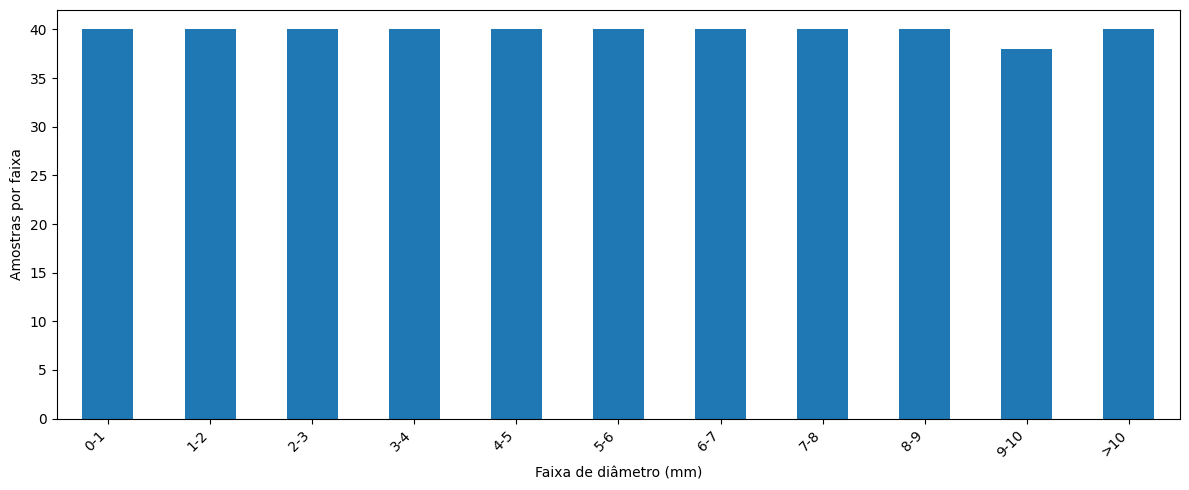

Aviso: 1 faixa(s) com menos de 40 amostras (dados insuficientes).
 - 9-10: 38 amostras


In [4]:
df_sampled, counts = sample_diameter(
    df_sorted,
    samples_per_bin=40
)

In [5]:
df_sampled

,image_name,"x coordinate in 0,0","y coordinate in 0,0",diameter (px),diameter (mm),area (px),area (mm2),group by diameter (px),diameter_mm_bin
6418,09_71.png,"[-5.053607416364457, -6.053607416364457, -7.05...","[-12.762595727529288, -11.762595727529288, -11...",31.064650,0.931939,413.5,0.37215,137,0-1
6700,15_336.png,"[-6.018348623853171, -7.018348623853171, -8.01...","[-9.9270423765837, -8.9270423765837, -7.927042...",27.122658,0.813680,381.5,0.34335,143,0-1
6466,01_21.png,"[-3.126152832674734, -4.126152832674734, -5.12...","[-12.898550724637971, -11.898550724637971, -11...",30.386461,0.911594,506.0,0.45540,138,0-1
6765,11_207.png,"[4.480266286257574, 3.4802662862575744, 2.4802...","[-10.495482643842138, -9.495482643842138, -9.4...",25.640154,0.769205,350.5,0.31545,145,0-1
6764,13_415.png,"[-3.842635658914787, -3.842635658914787, -4.84...","[-12.85658914728674, -11.85658914728674, -10.8...",25.659021,0.769771,215.0,0.19350,145,0-1
...,...,...,...,...,...,...,...,...,...
1,04_130.png,"[-136.91571097717508, -136.91571097717508, -13...","[-164.5143120895882, -163.5143120895882, -162....",486.319031,14.589571,71676.0,64.50840,1,>10
21,07_141.png,"[-42.949406174184446, -43.949406174184446, -44...","[-144.03654072791846, -143.03654072791846, -14...",380.979401,11.429382,74811.5,67.33035,1,>10
2,15_309.png,"[70.79459187168777, 69.79459187168777, 68.7945...","[-210.1569243788913, -209.1569243788913, -209....",481.328583,14.439857,41357.5,37.22175,1,>10
40,07_85.png,"[-61.05952689493233, -62.05952689493233, -63.0...","[-176.05971567620486, -175.05971567620486, -17...",347.466370,10.423991,52088.5,46.87965,1,>10


In [6]:
import numpy as np
import pandas as pd
from copy import deepcopy

def data_aug_bin(df_sampled: pd.DataFrame, bin_label: str, final_count: int, random_state: int = 42):
    """
    Aumenta (por rotação em torno da origem) o número de amostras na faixa `bin_label`
    até `final_count`. As rotações são uniformes em [0, 2π).

    Assumido que o DataFrame tem as colunas fixas:
      - "x coordinate in 0,0"
      - "y coordinate in 0,0"
      - "diameter_mm_bin"
      - "image_name"

    :param df_sampled: DataFrame original.
    :param bin_label: Rótulo da faixa (ex.: "9-10", ">10").
    :param final_count: Total desejado de amostras nessa faixa.
    :param random_state: Semente para reprodutibilidade (opcional).

    :return: Novo DataFrame contendo as amostras originais + as rotacionadas.
    """
    rng = np.random.default_rng(random_state)

    df = df_sampled.copy()
    mask = (df["diameter_mm_bin"] == bin_label)
    current = int(mask.sum())
    print(f"Tamanho inicial da faixa {bin_label}: {current}")

    needed = final_count - current
    pool = df.loc[mask]

    if pool.empty:
        print(f"Aviso: faixa '{bin_label}' está vazia; não foi possível augmentar.")
        return df

    choose_idx = rng.choice(pool.index.to_numpy(), size=needed, replace=True)

    new_rows = []
    for k, idx in enumerate(choose_idx, start=1):
        row = pool.loc[idx]

        # coords originais
        x = np.asarray(row["x coordinate in 0,0"], dtype=float)
        y = np.asarray(row["y coordinate in 0,0"], dtype=float)

        # rotação
        theta = rng.uniform(0.0, 2.0 * np.pi)
        c, s = np.cos(theta), np.sin(theta)
        x_rot = c * x - s * y
        y_rot = s * x + c * y

        new_row = deepcopy(row)
        new_row["x coordinate in 0,0"] = x_rot.tolist()
        new_row["y coordinate in 0,0"] = y_rot.tolist()
        new_row["image_name"] = f"{row['image_name']}__rot"

        new_rows.append(new_row)

    df_aug = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

    # Verificando tamanho final da faixa
    final = df_aug[df_aug["diameter_mm_bin"] == bin_label].shape[0]
    print(f"Tamanho final da faixa {bin_label}: {final}")

    return df_aug
    

In [7]:
df_aug = data_aug_bin(df_sampled, bin_label="9-10", final_count=50)

df_aug[df_aug["diameter_mm_bin"] == "9-10"]

Tamanho inicial da faixa 9-10: 38
Tamanho final da faixa 9-10: 50


,image_name,"x coordinate in 0,0","y coordinate in 0,0",diameter (px),diameter (mm),area (px),area (mm2),group by diameter (px),diameter_mm_bin
360,17_226.png,"[105.69868743689608, 104.69868743689608, 103.6...","[-98.36366446189027, -97.36366446189027, -97.3...",304.401276,9.132038,24265.5,21.83895,2,9-10
361,11_247.png,"[-61.63765457437512, -62.63765457437512, -63.6...","[-106.08848153659324, -105.08848153659324, -10...",300.787506,9.023625,38978.0,35.08020,2,9-10
362,05_81.png,"[-14.327337274355386, -15.327337274355386, -16...","[-162.3694734562132, -161.3694734562132, -161....",326.496765,9.794903,31548.5,28.39365,2,9-10
363,17_291.png,"[125.2876154029102, 124.2876154029102, 123.287...","[-120.60024107586855, -119.60024107586855, -11...",317.287354,9.518621,30834.0,27.75060,2,9-10
364,15_464.png,"[-48.525108026034104, -49.525108026034104, -50...","[-138.75029518139672, -137.75029518139672, -13...",306.584625,9.197539,40229.5,36.20655,2,9-10
365,08_100.png,"[-2.8161690560743864, -3.8161690560743864, -4....","[-153.92338404431007, -152.92338404431007, -15...",312.255035,9.367651,57022.5,51.32025,2,9-10
366,04_65.png,"[-7.288944974063952, -8.288944974063952, -9.28...","[-149.13760670470378, -148.13760670470378, -14...",325.510590,9.765318,41801.5,37.62135,2,9-10
367,09_58.png,"[59.68759741214535, 58.68759741214535, 57.6875...","[-121.9029995588885, -120.9029995588885, -120....",310.942322,9.328270,22670.0,20.40300,2,9-10
368,13_356.png,"[59.29528288931601, 58.29528288931601, 57.2952...","[-125.05031050688149, -124.05031050688149, -12...",312.698151,9.380945,43692.0,39.32280,2,9-10
369,11_271.png,"[-102.75876537595286, -103.75876537595286, -10...","[-81.63570902633398, -80.63570902633398, -80.6...",317.042786,9.511284,30784.0,27.70560,2,9-10


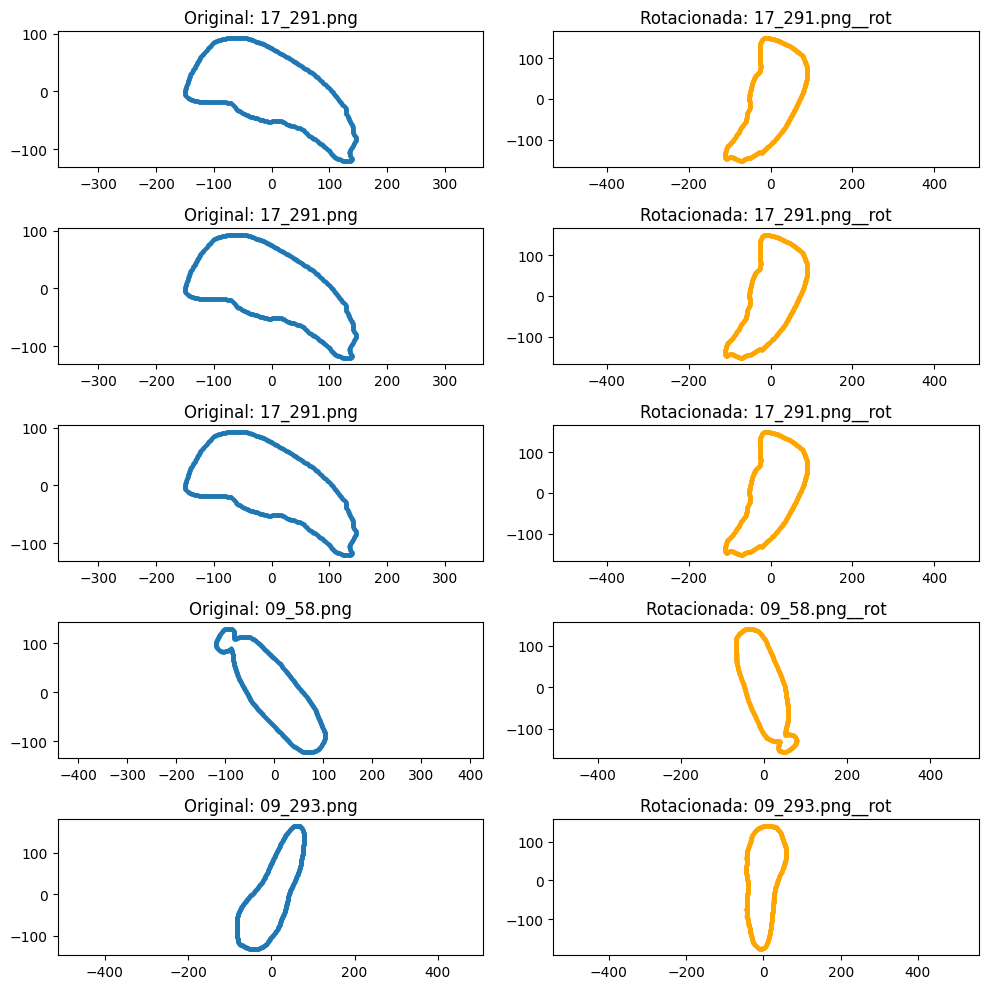

In [8]:
import matplotlib.pyplot as plt
import random
# todas as imagens rotacionadas
rot_names = df_aug[df_aug["image_name"].str.endswith("__rot")]["image_name"]

# recupera o nome base removendo o sufixo __rot
base_names = [n.replace("__rot", "") for n in rot_names]

# limita a 5 pares
pairs = list(zip(base_names, rot_names))
pairs = random.sample(pairs, min(len(pairs), 5))

fig, axs = plt.subplots(len(pairs), 2, figsize=(10, 2*len(pairs)))

if len(pairs) == 1:
    axs = [axs]

for i, (base_name, rot_name) in enumerate(pairs):
    # original
    row_orig = df_aug[df_aug["image_name"] == base_name].iloc[0]
    x_orig = row_orig["x coordinate in 0,0"]
    y_orig = row_orig["y coordinate in 0,0"]

    # rotacionada
    row_rot = df_aug[df_aug["image_name"] == rot_name].iloc[0]
    x_rot = row_rot["x coordinate in 0,0"]
    y_rot = row_rot["y coordinate in 0,0"]

    # plota original
    axs[i][0].plot(x_orig, y_orig, "-o", markersize=2)
    axs[i][0].set_title(f"Original: {base_name}")
    axs[i][0].axis("equal")

    # plota rotacionada
    axs[i][1].plot(x_rot, y_rot, "-o", markersize=2, color="orange")
    axs[i][1].set_title(f"Rotacionada: {rot_name}")
    axs[i][1].axis("equal")

plt.tight_layout()
plt.show()


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import MultiPoint

def plot_convex_hulls(df, names):
    """
    Para cada 'image_name' em `names`, busca no df, calcula o convex hull (Shapely)
    e plota o contorno original e o casco convexo lado a lado.
    """
    # filtra apenas os que existem no df
    missing = [n for n in names if not (df["image_name"] == n).any()]
    if missing is not None and len(missing) > 0:
        print(f"Faltando no df: {missing}")
    names   = [n for n in names if (df["image_name"] == n).any()]

    n = len(names)
    ncols = 4
    nrows = int(np.ceil(n / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(3.5*ncols, 3*nrows))
    axs = np.atleast_2d(axs)

    for i, name in enumerate(names):
        r, c = divmod(i, ncols)
        ax = axs[r, c]

        row = df[df["image_name"] == name].iloc[0]
        x = np.asarray(row["x coordinate in 0,0"], dtype=float)
        y = np.asarray(row["y coordinate in 0,0"], dtype=float)

        # pontos e casco convexo
        pts = np.column_stack([x, y])
        hull = MultiPoint(pts).convex_hull

        # plot contorno original (linhas e pontos)
        ax.plot(x, y, "-", linewidth=1)
        ax.plot(x, y, "o", markersize=1)

        # plot do casco convexo (compatível com Polygon/LineString/Point)
        if hull.geom_type == "Polygon":
            hx, hy = hull.exterior.xy
            ax.plot(hx, hy, linewidth=2)
        elif hull.geom_type == "LineString":
            hx, hy = hull.xy
            ax.plot(hx, hy, linewidth=2)
        else:  # Point
            hx, hy = hull.x, hull.y
            ax.plot(hx, hy, "o", markersize=4)

        ax.set_title(name, fontsize=9)
        ax.axis("equal")
        ax.set_xticks([])
        ax.set_yticks([])

    # apaga eixos sobrando
    total_axes = nrows * ncols
    for j in range(n, total_axes):
        axs.flat[j].axis("off")

    plt.tight_layout()
    plt.show()


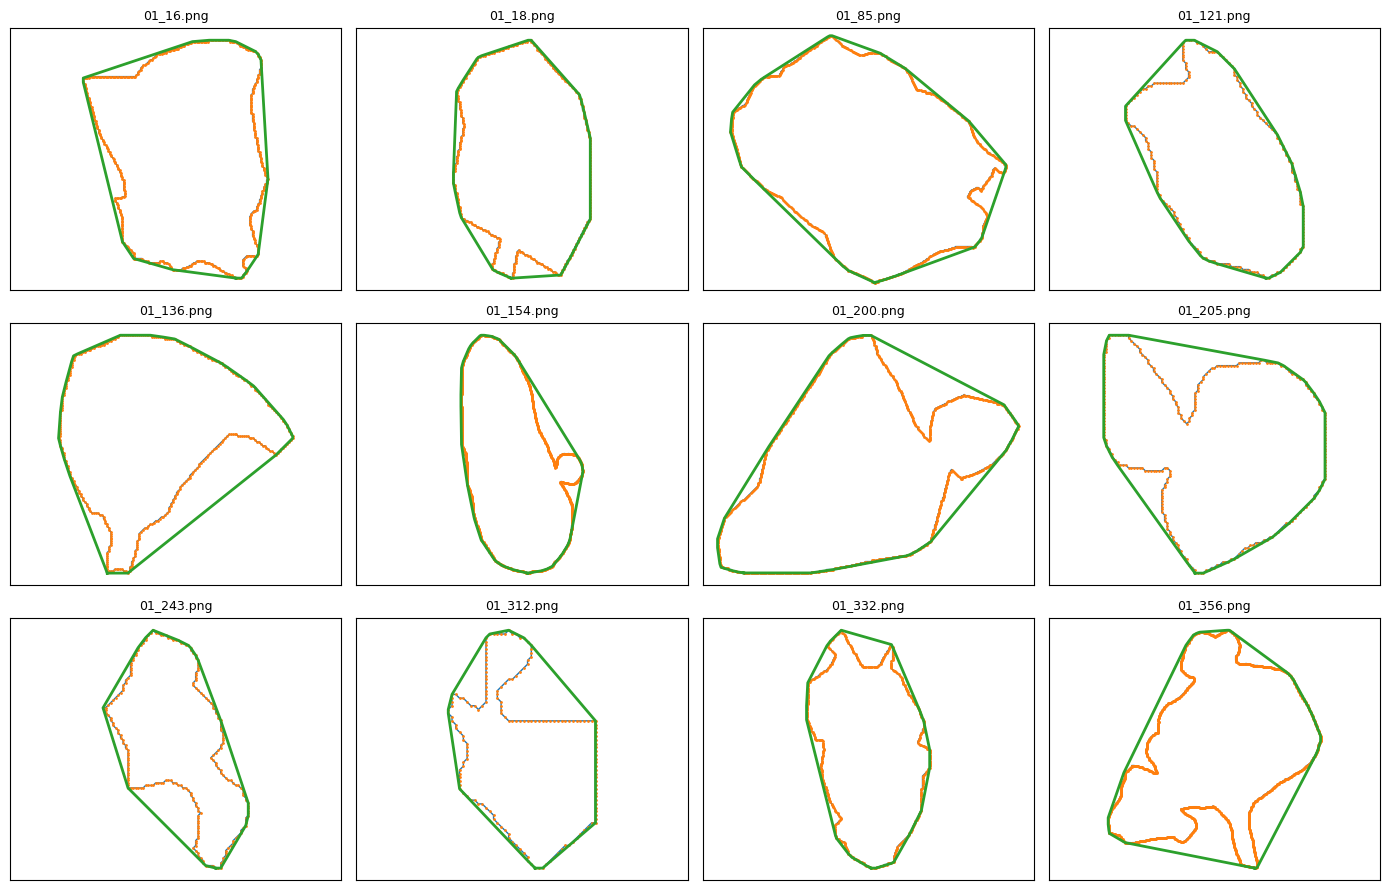

In [10]:
list_convex_hull = [
    "01_16.png","01_18.png","01_85.png","01_121.png","01_136.png","01_154.png",
    "01_200.png","01_205.png","01_243.png","01_312.png","01_332.png","01_356.png"
]

plot_convex_hulls(df_sorted, list_convex_hull)


In [11]:
import numpy as np
from shapely.geometry import MultiPoint

def hull_from_xy(x: list, y: list, type_hull: str = "convex", approx_tol: float = 1.0) -> tuple[list, list]:
    """
    Calcula um hull a partir de coordenadas (x, y) e retorna as listas.

    :param x: lista de coordenadas x
    :param y: lista de coordenadas y
    :param type_hull: "convex" para convex hull (default) ou "approx" para hull simplificado
    :param approx_tol: tolerância de simplificação usada no tipo "approx"

    :return: (x_h, y_h) listas de coordenadas do hull
    """
    pts = np.column_stack([np.asarray(x, dtype=float), np.asarray(y, dtype=float)])
    hull = MultiPoint(pts).convex_hull

    if type_hull == "approx":
        hull = hull.simplify(approx_tol, preserve_topology=True)

    if hull.geom_type == "Polygon":
        hx, hy = hull.exterior.xy
        return list(hx), list(hy)
    elif hull.geom_type == "LineString":
        hx, hy = hull.xy
        return list(hx), list(hy)
    else:  # Point
        return [hull.x], [hull.y]


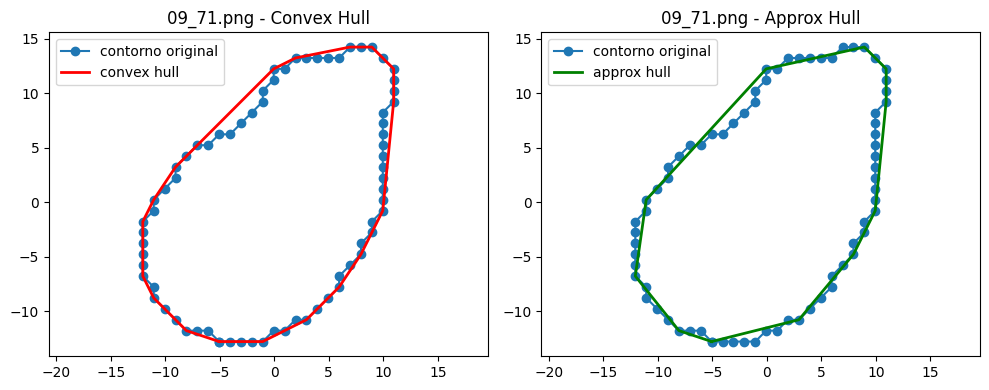

Quantidade de pontos Original: 72
Quantidade de pontos Convex Hull: 19
Quantidade de pontos Approx Hull: 12


In [23]:
# escolhe um contorno qualquer do df_aug
row = df_aug.iloc[0]   # primeira linha como exemplo
name = row["image_name"]

x = row["x coordinate in 0,0"]
y = row["y coordinate in 0,0"]

# calcula hull convex e approx
x_conv, y_conv = hull_from_xy(x, y, type_hull="convex")
x_appr, y_appr = hull_from_xy(x, y, type_hull="approx", approx_tol=1.0)

# plota os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(x, y, "o-", label="contorno original")
plt.plot(x_conv, y_conv, "-r", linewidth=2, label="convex hull")
plt.axis("equal"); plt.title(f"{name} - Convex Hull"); plt.legend()

plt.subplot(1,2,2)
plt.plot(x, y, "o-", label="contorno original")
plt.plot(x_appr, y_appr, "-g", linewidth=2, label="approx hull")
plt.axis("equal"); plt.title(f"{name} - Approx Hull"); plt.legend()

plt.tight_layout()
plt.show()

print("Quantidade de pontos Original:", len(x))
print("Quantidade de pontos Convex Hull:", len(x_conv))
print("Quantidade de pontos Approx Hull:", len(x_appr))


In [15]:
import numpy as np
from shapely.geometry import Polygon, LineString, Point

def offset_polygon_xy(x: list, y: list, offset: float, join_style: str = "round", resolution: int = 5) -> tuple[list, list]:
    """
    Aplica um offset (buffer) a um contorno definido por (x, y).

    :param x: lista de coordenadas x do contorno
    :param y: lista de coordenadas y do contorno
    :param offset: distância do offset ( >0 dilata / <0 erode )
    :param join_style: 'round' (padrão), 'mitre'/'miter', ou 'bevel'
    :param resolution: suavidade das curvas no buffer (padrão=16)

    :return: (x_off, y_off) listas com o contorno offsetado
    """
    pts = np.column_stack([np.asarray(x, dtype=float), np.asarray(y, dtype=float)])
    n = len(pts)

    # escolhe uma geometria base válida para o buffer
    if n >= 3:
        geom = Polygon(pts)
        if (not geom.is_valid) or (geom.area <= 0):
            geom = LineString(pts)
    elif n == 2:
        geom = LineString(pts)
    elif n == 1:
        geom = Point(pts[0])
    else:
        return [], []

    js = {"round": 1, "mitre": 2, "miter": 2, "bevel": 3}.get(join_style.lower(), 1)
    out = geom.buffer(offset, join_style=js, resolution=resolution)

    if out.is_empty:
        return [], []

    # pega um polígono simples para devolver coordenadas do exterior
    if out.geom_type == "MultiPolygon":
        poly = max(out.geoms, key=lambda g: g.area)
    elif out.geom_type == "Polygon":
        poly = out
    else:
        # se não virar polígono (caso muito degenerado), devolve coords diretas
        if hasattr(out, "coords"):
            xs, ys = zip(*list(out.coords))
            return list(xs), list(ys)
        return [], []

    xs, ys = poly.exterior.xy
    return list(xs), list(ys)


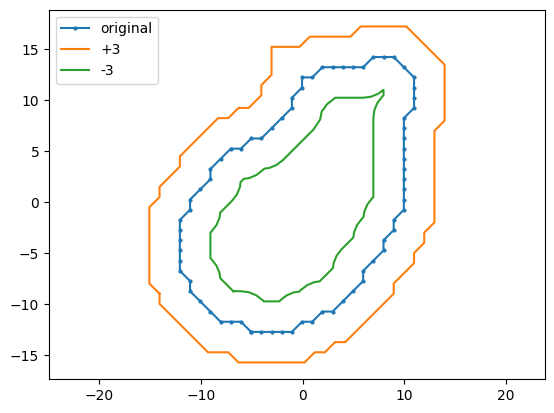

In [20]:
# pega um contorno do df_aug
row = df_aug.iloc[0]
x = row["x coordinate in 0,0"]
y = row["y coordinate in 0,0"]

# expande em +3 px e contrai em -3 px (ajuste unidades conforme seu sistema)
x_out, y_out = offset_polygon_xy(x, y, offset=3.0, join_style="mitre")
x_in,  y_in  = offset_polygon_xy(x, y, offset=-3.0, join_style="round")

# plot para conferir
import matplotlib.pyplot as plt
plt.plot(x, y, "-o", markersize=2, label="original")
plt.plot(x_out, y_out, "-", label="+3")
plt.plot(x_in, y_in, "-", label="-3")
plt.axis("equal"); plt.legend(); plt.show()
